In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob

import warnings
warnings.filterwarnings('ignore')

In [72]:
path_experiments = "/fsx-gum/carohiguera/"
experiments = ['tacbench_700k_vitbase', 'tacbench_460k_vitbase', 'tacbench_700k_vitsmall',]
task_names = ['t1_force_digit', 't1_force_gelsight', 't2_slip_digit', 't2_slip_gelsight', 't3_pose_digit', 't4_grasp_gelsight', 't6_textile_gelsight']
# task_names = ['t1_force_digit']
eval_ssl_models = ['mae', 'dino', 'dinov2', 'ijepa', 'vjepa']
eval_data_budget = [1.0, 0.33, 0.1, 0.01]

In [73]:
sns.set_theme(context='notebook', style='whitegrid',font='sans-serif', font_scale=1, rc=None)
colors = sns.color_palette("colorblind", 10)

model_labels = {
    'e2e': 'E2E',
    'mae': 'MAE',
    'dino': 'DINO',
    'dinov2': 'DINOv2',
    'ijepa': 'I-JEPA',
    'vjepa': 'V-JEPA',
}
model_colors = {
    'e2e': colors[1],
    'mae': colors[0],
    'dino': colors[7],
    'dinov2': colors[8],
    'ijepa': colors[2],
    'vjepa': colors[4],
}
data_labels = {
    1.0: 'Full dataset',
    0.33: '1/3 dataset',
    0.1: '1/10 dataset',
    0.01: '1/100 dataset'
}
metric_name = {
    't1_force_digit': 'RMSE (mN)',
    't1_force_gelsight': 'RMSE (mN)',
    't2_slip_digit': 'F1 score',
    't2_slip_gelsight': 'F1 score',
    't3_pose_digit': 'Accuracy',
    't4_grasp_gelsight': 'Accuracy',
    't6_textile_gelsight': 'Accuracy'
}

In [74]:
def get_output(path_experiments, experiment, task_name, m, ssl_size, b):
    path_model_outputs = []
    files = os.listdir(f"{path_experiments}/{experiment}/{task_name}/")
    for f in files:
        if f.endswith(f"_{m}_{ssl_size}_{b}"):
            path_model_outputs.append(f)
            break
    return path_model_outputs

In [75]:
def get_t1_force_metrics(path_experiments, experiment, task_name):
    global data_labels, model_labels

    sensor = task_name.split('_')[-1]
    task = task_name.split('_')[0] + '_' + task_name.split('_')[1]
    ssl_size = experiment.split('_')[-1]

    metrics_rmse = pd.DataFrame(columns=['Model']+list(data_labels.values()))
    metrics_ci = pd.DataFrame(columns=['Model']+list(data_labels.values()))
    # add as rows the model_labels values
    for m in eval_ssl_models:
        metrics_rmse = pd.concat([metrics_rmse, pd.DataFrame({'Model': [model_labels[m]]})])
        metrics_ci = pd.concat([metrics_ci, pd.DataFrame({'Model': [model_labels[m]]})])
    metrics_rmse = metrics_rmse.reset_index(drop=True)
    metrics_ci = metrics_ci.reset_index(drop=True)

    for b in eval_data_budget:
        for m in eval_ssl_models:
            metrics_all_epochs = pd.DataFrame(columns=['epoch', 'rmse', 'rmse-std', 'ci95', 'n_samples'])

            path_model_outputs = get_output(path_experiments, experiment, task_name, m, ssl_size, b)
            
            if len(path_model_outputs) == 0:
                continue
            elif len(path_model_outputs) > 1:
                print('More than one model found')
                print(path_model_outputs)
                continue
            else:
                path_model_outputs = f"{path_experiments}/{experiment}/{task_name}/{path_model_outputs[0]}/"

            if not os.path.exists(path_model_outputs):
                continue
            all_epochs = sorted([int(f.split('_')[0]) for f in os.listdir(path_model_outputs) if f.endswith('_metrics.npy')])
            for epoch in all_epochs:
                path_metrics = f"{path_model_outputs}/{epoch}_metrics.npy"
                metrics_exp = np.load(path_metrics, allow_pickle=True).item()
                # print(metrics_exp)
                metrics_ep = pd.DataFrame(
                    {'epoch': [epoch], 
                    'rmse': [metrics_exp['rmse']], 
                    'rmse-std': [metrics_exp['rmse_std']], 
                    'ci95': [metrics_exp['ci95']], 
                    'n_samples': [metrics_exp['n_samples']]}
                )
                metrics_all_epochs = pd.concat([metrics_all_epochs, metrics_ep])

            metrics_all_epochs = metrics_all_epochs.reset_index(drop=True)
            best_rmse = metrics_all_epochs['rmse'].min() * 1000.0
            best_ci95 = metrics_all_epochs.loc[metrics_all_epochs['ci95'].idxmin()]['ci95']

            metrics_rmse.loc[metrics_rmse['Model'] == model_labels[m], data_labels[b]] = best_rmse
            metrics_ci.loc[metrics_ci['Model'] == model_labels[m], data_labels[b]] = best_ci95

    print(f"Experiment: {experiment}, Task: {task_name}")
    print('Metrics RMSE (mN)')
    print(metrics_rmse)
    print('\nMetrics Confidence Interval 95%')
    print(metrics_ci)
    print('---------------------------------------------------------------')
    print('\n')

    return metrics_rmse, metrics_ci

In [76]:
def get_t2_slip_metrics(path_experiments, experiment, task_name):
    global data_labels, model_labels

    sensor = task_name.split('_')[-1]
    task = task_name.split('_')[0] + '_' + task_name.split('_')[1]
    ssl_size = experiment.split('_')[-1]

    metrics_f1score = pd.DataFrame(columns=['Model']+list(data_labels.values()))
    metrics_slip_acc = pd.DataFrame(columns=['Model']+list(data_labels.values()))
    # add as rows the model_labels values
    for m in eval_ssl_models:
        metrics_f1score = pd.concat([metrics_f1score, pd.DataFrame({'Model': [model_labels[m]]})])
        metrics_slip_acc = pd.concat([metrics_slip_acc, pd.DataFrame({'Model': [model_labels[m]]})])
    metrics_f1score = metrics_f1score.reset_index(drop=True)
    metrics_slip_acc = metrics_slip_acc.reset_index(drop=True)

    for b in eval_data_budget:
        for m in eval_ssl_models:
            metrics_all_epochs = pd.DataFrame(columns=['epoch', 'f1-score', 'acc_slip', 'n_samples'])

            path_model_outputs = get_output(path_experiments, experiment, task_name, m, ssl_size, b)
            
            if len(path_model_outputs) == 0:
                continue
            elif len(path_model_outputs) > 1:
                print('More than one model found')
                print(path_model_outputs)
                continue
            else:
                path_model_outputs = f"{path_experiments}/{experiment}/{task_name}/{path_model_outputs[0]}/"

            if not os.path.exists(path_model_outputs):
                continue
            all_epochs = sorted([int(f.split('_')[0]) for f in os.listdir(path_model_outputs) if f.endswith('_metrics.npy')])
            for epoch in all_epochs:
                path_metrics = f"{path_model_outputs}/{epoch}_metrics.npy"
                metrics_exp = np.load(path_metrics, allow_pickle=True).item()
                metrics_ep = pd.DataFrame({'epoch': [epoch], 'f1-score': [metrics_exp['slip/f1-score']], 'acc_slip': [metrics_exp['balanced_accuracy']], 'n_samples': [metrics_exp['n_samples']]})
                metrics_all_epochs = pd.concat([metrics_all_epochs, metrics_ep])

            metrics_all_epochs = metrics_all_epochs.reset_index(drop=True)
            best_f1_score = metrics_all_epochs['f1-score'].max()
            best_acc_slip = metrics_all_epochs.loc[metrics_all_epochs['f1-score'].idxmax()]['acc_slip']


            metrics_f1score.loc[metrics_f1score['Model'] == model_labels[m], data_labels[b]] = best_f1_score
            metrics_slip_acc.loc[metrics_slip_acc['Model'] == model_labels[m], data_labels[b]] = best_acc_slip

    print(f"Experiment: {experiment}, Task: {task_name}")
    print('Metrics F1-score')
    print(metrics_f1score)
    print('\nMetrics slip accuracy')
    print(metrics_slip_acc)
    print('---------------------------------------------------------------')
    print('\n')

    return metrics_f1score, None

In [77]:
def get_t3_pose_metrics(path_experiments, experiment, task_name):
    global data_labels, model_labels

    sensor = task_name.split('_')[-1]
    task = task_name.split('_')[0] + '_' + task_name.split('_')[1]
    ssl_size = experiment.split('_')[-1]

    metrics_acc = pd.DataFrame(columns=['Model']+list(data_labels.values()))
    metrics_ci = pd.DataFrame(columns=['Model']+list(data_labels.values()))
    # add as rows the model_labels values
    for m in eval_ssl_models:
        metrics_acc = pd.concat([metrics_acc, pd.DataFrame({'Model': [model_labels[m]]})])
        metrics_ci = pd.concat([metrics_ci, pd.DataFrame({'Model': [model_labels[m]]})])
    metrics_acc = metrics_acc.reset_index(drop=True)
    metrics_ci = metrics_ci.reset_index(drop=True)

    for b in eval_data_budget:
        for m in eval_ssl_models:
            metrics_all_epochs = pd.DataFrame(columns=['epoch', 'acc', 'acc-std', 'ci95', 'n_samples'])
            # path_model_outputs = f"{path_outputs_tacbench}/{task}_{sensor}/{sensor}_{task}_{m}_{eval_ssl_size}_{b}/"

            path_model_outputs = get_output(path_experiments, experiment, task_name, m, ssl_size, b)
            
            if len(path_model_outputs) == 0:
                continue
            elif len(path_model_outputs) > 1:
                print('More than one model found')
                print(path_model_outputs)
                continue
            else:
                path_model_outputs = f"{path_experiments}/{experiment}/{task_name}/{path_model_outputs[0]}/"

            if not os.path.exists(path_model_outputs):
                continue
            all_epochs = sorted([int(f.split('_')[0]) for f in os.listdir(path_model_outputs) if f.endswith('_metrics.npy')])
            for epoch in all_epochs:
                path_metrics = f"{path_model_outputs}/{epoch}_metrics.npy"
                metrics_exp = np.load(path_metrics, allow_pickle=True).item()
                # print(metrics_exp)
                metrics_ep = pd.DataFrame(
                    {'epoch': [epoch], 
                    'acc': [metrics_exp['test_datasets_avg_acc']], 
                    'acc-std': [metrics_exp['test_datasets_sd_acc']], 
                    'ci95': [metrics_exp['test_datasets_ci95']], 
                    'n_samples': [metrics_exp['n_samples']]}
                )
                metrics_all_epochs = pd.concat([metrics_all_epochs, metrics_ep])

            metrics_all_epochs = metrics_all_epochs.reset_index(drop=True)
            best_acc = metrics_all_epochs['acc'].max()
            best_ci95 = metrics_all_epochs.loc[metrics_all_epochs['acc'].idxmax()]['ci95']

            metrics_acc.loc[metrics_acc['Model'] == model_labels[m], data_labels[b]] = best_acc
            metrics_ci.loc[metrics_ci['Model'] == model_labels[m], data_labels[b]] = best_ci95

    print(f"Experiment: {experiment}, Task: {task_name}")
    print('Metrics Accuracy')
    print(metrics_acc)
    print('\nMetrics Confidence Interval 95%')
    print(metrics_ci)
    print('---------------------------------------------------------------')
    print('\n')

    return metrics_acc, metrics_ci

In [78]:
def get_t4_grasp_metrics(path_experiments, experiment, task_name):
    global data_labels, model_labels

    sensor = task_name.split('_')[-1]
    task = task_name.split('_')[0] + '_' + task_name.split('_')[1]
    ssl_size = experiment.split('_')[-1]

    metrics_acc = pd.DataFrame(columns=['Model']+list(data_labels.values()))
    metrics_ci = pd.DataFrame(columns=['Model']+list(data_labels.values()))
    # add as rows the model_labels values
    for m in eval_ssl_models:
        metrics_acc = pd.concat([metrics_acc, pd.DataFrame({'Model': [model_labels[m]]})])
        metrics_ci = pd.concat([metrics_ci, pd.DataFrame({'Model': [model_labels[m]]})])
    metrics_acc = metrics_acc.reset_index(drop=True)
    metrics_ci = metrics_ci.reset_index(drop=True)

    for b in eval_data_budget:
        for m in eval_ssl_models:
            metrics_all_epochs = pd.DataFrame(columns=['epoch', 'acc', 'acc-std', 'ci95', 'n_samples'])
            # path_model_outputs = f"{path_outputs_tacbench}/{task}_{sensor}/{sensor}_{task}_{m}_{eval_ssl_size}_{b}/"

            path_model_outputs = get_output(path_experiments, experiment, task_name, m, ssl_size, b)
            
            if len(path_model_outputs) == 0:
                continue
            elif len(path_model_outputs) > 1:
                print('More than one model found')
                print(path_model_outputs)
                continue
            else:
                path_model_outputs = f"{path_experiments}/{experiment}/{task_name}/{path_model_outputs[0]}/"

            if not os.path.exists(path_model_outputs):
                continue
            all_epochs = sorted([int(f.split('_')[0]) for f in os.listdir(path_model_outputs) if f.endswith('_metrics.npy')])
            for epoch in all_epochs:
                path_metrics = f"{path_model_outputs}/{epoch}_metrics.npy"
                metrics_exp = np.load(path_metrics, allow_pickle=True).item()
                # print(metrics_exp)
                metrics_ep = pd.DataFrame(
                    {'epoch': [epoch], 
                    'acc': [metrics_exp['test_datasets_avg_acc']], 
                    'acc-std': [metrics_exp['test_datasets_sd_acc']], 
                    'ci95': [metrics_exp['test_datasets_ci95']], 
                    'n_samples': [metrics_exp['n_samples']]}
                )
                metrics_all_epochs = pd.concat([metrics_all_epochs, metrics_ep])

            metrics_all_epochs = metrics_all_epochs.reset_index(drop=True)
            best_acc = metrics_all_epochs['acc'].max()
            best_ci95 = metrics_all_epochs.loc[metrics_all_epochs['acc'].idxmax()]['ci95']

            metrics_acc.loc[metrics_acc['Model'] == model_labels[m], data_labels[b]] = best_acc
            metrics_ci.loc[metrics_ci['Model'] == model_labels[m], data_labels[b]] = best_ci95

    print(f"Experiment: {experiment}, Task: {task_name}")
    print('Metrics Accuracy')
    print(metrics_acc)
    print('\nMetrics Confidence Interval 95%')
    print(metrics_ci)
    print('---------------------------------------------------------------')
    print('\n')

    return metrics_acc, metrics_ci

In [79]:
def get_t6_textile_metrics(path_experiments, experiment, task_name):
    global data_labels, model_labels

    sensor = task_name.split('_')[-1]
    task = task_name.split('_')[0] + '_' + task_name.split('_')[1]
    ssl_size = experiment.split('_')[-1]

    metrics_acc = pd.DataFrame(columns=['Model']+list(data_labels.values()))
    metrics_ci = pd.DataFrame(columns=['Model']+list(data_labels.values()))
    # add as rows the model_labels values
    for m in eval_ssl_models:
        metrics_acc = pd.concat([metrics_acc, pd.DataFrame({'Model': [model_labels[m]]})])
        metrics_ci = pd.concat([metrics_ci, pd.DataFrame({'Model': [model_labels[m]]})])
    metrics_acc = metrics_acc.reset_index(drop=True)
    metrics_ci = metrics_ci.reset_index(drop=True)

    for b in eval_data_budget:
        for m in eval_ssl_models:
            metrics_all_epochs = pd.DataFrame(columns=['epoch', 'acc', 'acc-std', 'ci95', 'n_samples'])
            # path_model_outputs = f"{path_outputs_tacbench}/{task}_{sensor}/{sensor}_{task}_{m}_{eval_ssl_size}_{b}/"
            
            path_model_outputs = get_output(path_experiments, experiment, task_name, m, ssl_size, b)
            
            if len(path_model_outputs) == 0:
                continue
            elif len(path_model_outputs) > 1:
                print('More than one model found')
                print(path_model_outputs)
                continue
            else:
                path_model_outputs = f"{path_experiments}/{experiment}/{task_name}/{path_model_outputs[0]}/"

            if not os.path.exists(path_model_outputs):
                continue
            all_epochs = sorted([int(f.split('_')[0]) for f in os.listdir(path_model_outputs) if f.endswith('_metrics.npy')])
            for epoch in all_epochs:
                path_metrics = f"{path_model_outputs}/{epoch}_metrics.npy"
                metrics_exp = np.load(path_metrics, allow_pickle=True).item()
                # print(metrics_exp)
                metrics_ep = pd.DataFrame(
                    {'epoch': [epoch], 
                    'acc': [metrics_exp['test_datasets_avg_acc']], 
                    'acc-std': [metrics_exp['test_datasets_sd_acc']], 
                    'ci95': [metrics_exp['test_datasets_ci95']], 
                    'n_samples': [metrics_exp['n_samples']]}
                )
                metrics_all_epochs = pd.concat([metrics_all_epochs, metrics_ep])

            metrics_all_epochs = metrics_all_epochs.reset_index(drop=True)
            best_acc = metrics_all_epochs['acc'].max()
            best_ci95 = metrics_all_epochs.loc[metrics_all_epochs['acc'].idxmax()]['ci95']

            metrics_acc.loc[metrics_acc['Model'] == model_labels[m], data_labels[b]] = best_acc
            metrics_ci.loc[metrics_ci['Model'] == model_labels[m], data_labels[b]] = best_ci95

    print(f"Experiment: {experiment}, Task: {task_name}")
    print('Metrics Accuracy')
    print(metrics_acc)
    print('\nMetrics Confidence Interval 95%')
    print(metrics_ci)
    print('---------------------------------------------------------------')
    print('\n')

    return metrics_acc, metrics_ci

In [80]:
results = {}
for experiment in experiments:
    results[experiment] = {}
    for task_name in task_names:
        results[experiment][task_name] = {}
        if 'force' in task_name:
            metric, ci = get_t1_force_metrics(path_experiments, experiment, task_name)
        elif 'slip' in task_name:
            metric, ci = get_t2_slip_metrics(path_experiments, experiment, task_name)
        elif 'pose' in task_name:
            metric, ci = get_t3_pose_metrics(path_experiments, experiment, task_name)
        elif 'grasp' in task_name:
            metric, ci = get_t4_grasp_metrics(path_experiments, experiment, task_name)
        elif 'textile' in task_name:
            metric, ci = get_t6_textile_metrics(path_experiments, experiment, task_name)
        results[experiment][task_name]['metric'] = metric
        results[experiment][task_name]['ci'] = ci
# metric, ci = get_t1_force_metrics(path_experiments, experiments[2], task_names[0])

Experiment: tacbench_700k_vitbase, Task: t1_force_digit
Metrics RMSE (mN)
    Model Full dataset 1/3 dataset 1/10 dataset 1/100 dataset
0     MAE    28.367762    23.99087    28.473499    133.176785
1    DINO     23.34787   26.112909    37.618463    184.949483
2  DINOv2    36.264256   34.098339    43.503385    180.662227
3  I-JEPA     34.55909   36.547392    52.611881    218.109079
4  V-JEPA    27.671367   29.821206    41.809356    195.010883

Metrics Confidence Interval 95%
    Model Full dataset 1/3 dataset 1/10 dataset 1/100 dataset
0     MAE     0.000209    0.000178     0.000209      0.000962
1    DINO     0.000167    0.000191     0.000281      0.001382
2  DINOv2     0.000263    0.000253      0.00032      0.001362
3  I-JEPA     0.000255    0.000276     0.000413      0.001552
4  V-JEPA     0.000207     0.00022     0.000308      0.001466
---------------------------------------------------------------


Experiment: tacbench_700k_vitbase, Task: t1_force_gelsight
Metrics RMSE (mN)
    Mo

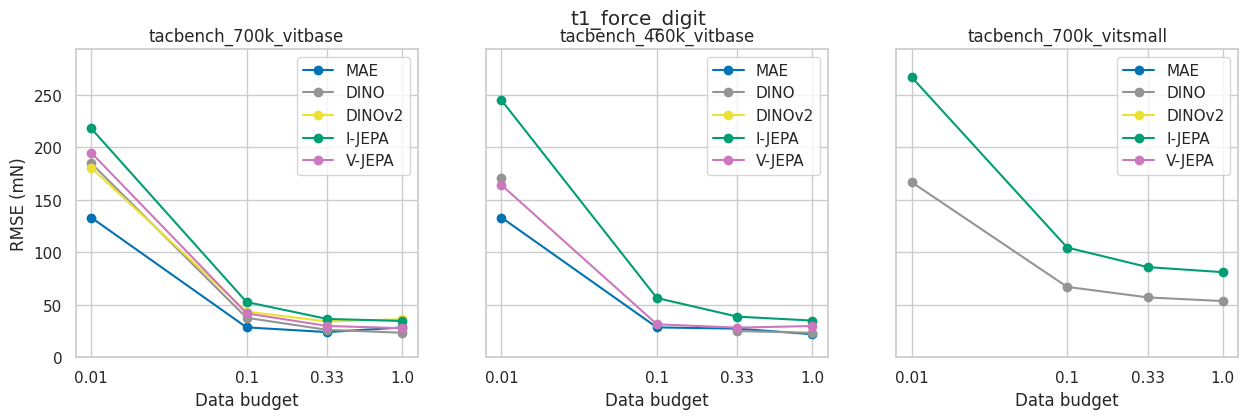

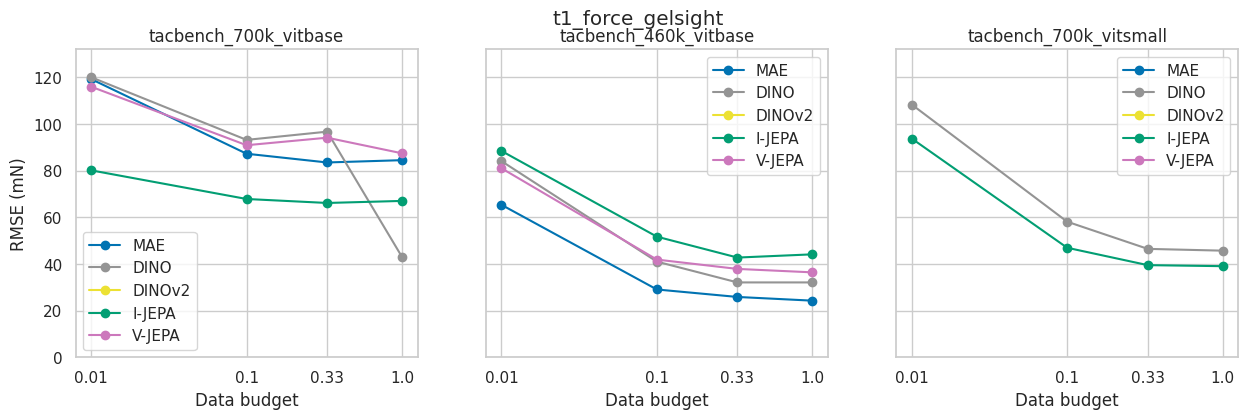

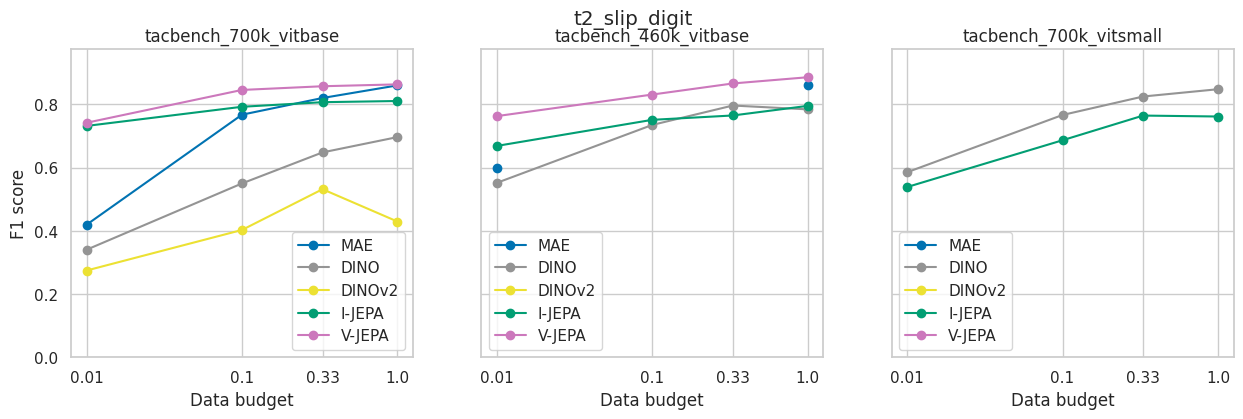

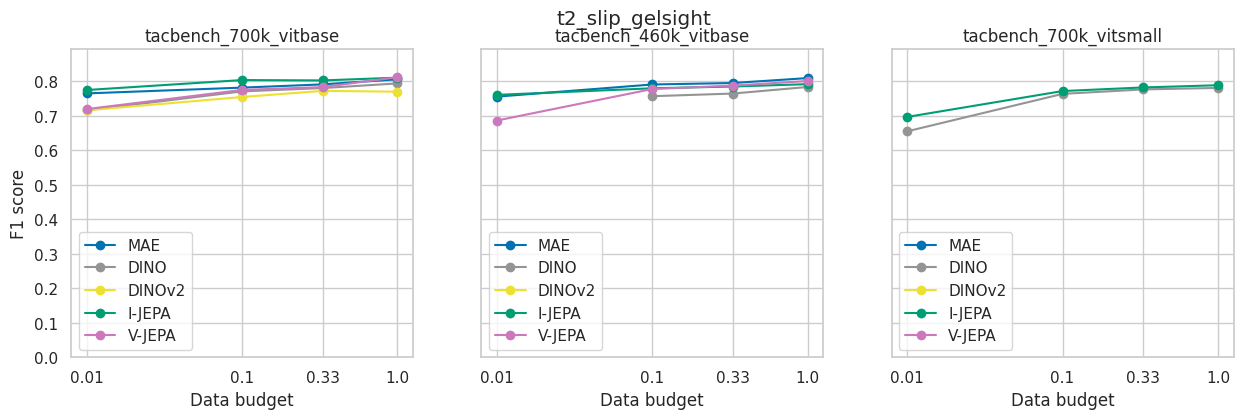

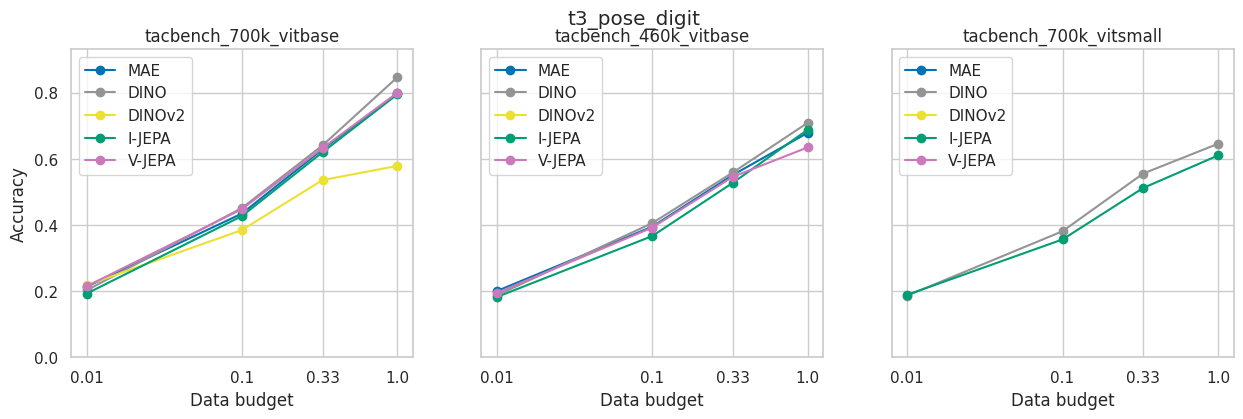

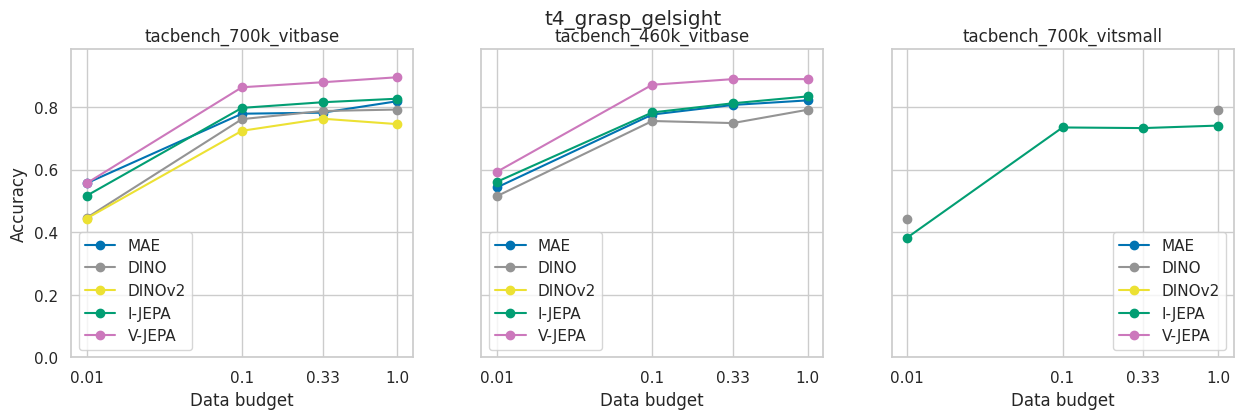

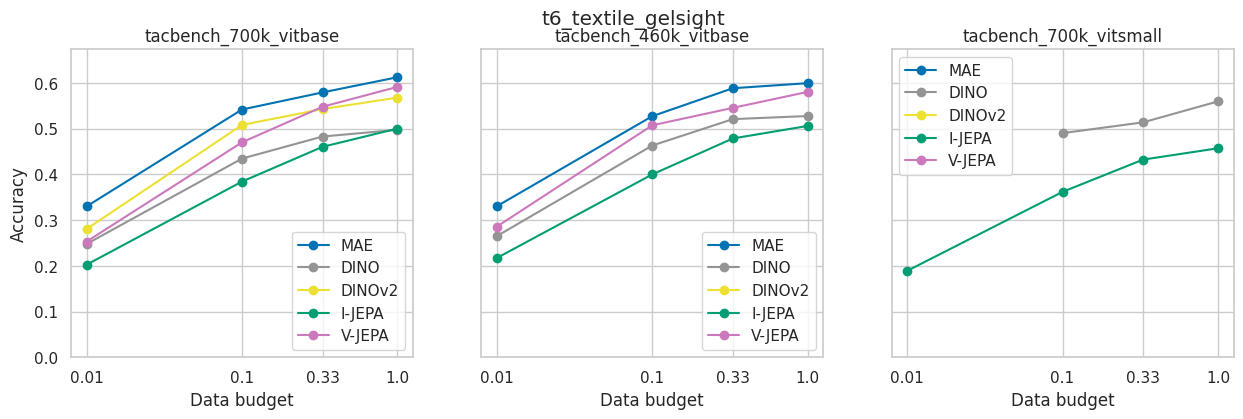

In [81]:
# plots for each task
x = np.array(list(data_labels.keys()))[::-1]
for task_name in task_names:
    ymax = 0
    fig, ax = plt.subplots(1, len(experiments), figsize=(15, 4), sharey=True, sharex=True)
    
    for experiment in experiments:
        metric = results[experiment][task_name]['metric']
        if metric.max()[1:].max() > ymax:
            ymax = metric.max()[1:].max()

        for ssl_model in eval_ssl_models:
            data = metric.loc[metric['Model'] == model_labels[ssl_model]]
            # ax[experiments.index(experiment)].plot(data.columns[1:][::-1], xdata.values[0][1:][::-1], label=model_labels[ssl_model], color=model_colors[ssl_model], marker='o')
            ax[experiments.index(experiment)].plot(x, data.values[0][1:][::-1], label=model_labels[ssl_model], color=model_colors[ssl_model], marker='o')
        ax[experiments.index(experiment)].set_title(f"{experiment}")
        ax[experiments.index(experiment)].set_xlabel('Data budget')
        ax[experiments.index(experiment)].set_xscale('log')
        ax[experiments.index(experiment)].set_xticks(x)
        ax[experiments.index(experiment)].set_xticklabels(x)
        ax[experiments.index(experiment)].legend()
        # set log scale for x axis
        
    for a in ax:
        a.set_ylim([0, ymax*1.1])
    ax[0].set_ylabel(metric_name[task_name])
    plt.suptitle(f"{task_name}")
    plt.show()
    
        